# Koulutetaan Faster R-CNN objekti tunnistus algoritmi ilmaisella GPU:lla

## Autetikaatio




In [4]:
# Tarvittavat kirjastot
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

import shutil
shutil.rmtree('/content/drive', ignore_errors=True)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Authenticated
Mounted at /content/drive


## Kouluta malli

In [ ]:
# Tarvittavat kirjastot
!pip install torch torchvision pycocotools matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from PIL import ImageDraw
import torchvision.transforms.functional as F
import os
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import time


from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import random
from google.colab import files

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import random
import requests
import io
import numpy as np
import matplotlib.patches as patches

In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Käytetään laitetta: {device}")

Käytetään laitetta: cuda


In [ ]:
# Määritellään polut
ANNOTATION_FILE = '/content/drive/MyDrive/mansikka/datas/instances_default.json'
IMAGE_DIR = '/content/drive/MyDrive/mansikka/datas/photos'

In [ ]:
class LabelDetectionDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        try:
            img_id = self.ids[index]
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            coco_annotation = self.coco.loadAnns(ann_ids)

            path = self.coco.loadImgs(img_id)[0]['file_name']
            img = Image.open(os.path.join(self.root, path)).convert("RGB")

            num_objs = len(coco_annotation)
            boxes = []
            for i in range(num_objs):
                xmin = coco_annotation[i]['bbox'][0]
                ymin = coco_annotation[i]['bbox'][1]
                xmax = xmin + coco_annotation[i]['bbox'][2]
                ymax = ymin + coco_annotation[i]['bbox'][3]
                boxes.append([xmin, ymin, xmax, ymax])

            # Tarkista, että boxes ei ole tyhjä
            if len(boxes) == 0:
                # Jos kuva ei sisällä yhtään kohdetta, palautetaan tyhjä tensori
                boxes = torch.zeros((0, 4), dtype=torch.float32)
            else:
                boxes = torch.as_tensor(boxes, dtype=torch.float32)

            labels = torch.ones((num_objs,), dtype=torch.int64)  # Kaikki kohteet ovat etikettejä (luokka 1)

            image_id = torch.tensor([img_id])

            # Tarkista, että boxes ei ole tyhjä ennen area-laskelmaa
            if boxes.numel() > 0:
                area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            else:
                area = torch.zeros((0,), dtype=torch.float32)

            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            # Muunna kuva tensoriksi
            img = F.to_tensor(img)

            return img, target
        except Exception as e:
            print(f"Virhe käsiteltäessä kuvaa indeksillä {index}: {str(e)}")
            return None

    def __len__(self):
        return len(self.ids)

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return tuple(zip(*batch))

def plot_loss(epochs, losses):
    plt.figure(figsize=(10,5))
    plt.plot(epochs, losses)
    plt.title('Koulutuksen häviö')
    plt.xlabel('Epookki')
    plt.ylabel('Häviö')
    plt.savefig('/content/drive/MyDrive/mansikka/datas/training_loss.png')
    plt.close()

# Datan lataaminen
dataset = LabelDetectionDataset(IMAGE_DIR, ANNOTATION_FILE)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

# Mallin koulutus
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Käytetään laitetta: {device}")

num_classes = 2  # Tausta ja etiketti
model = get_model(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 12
epoch_losses = []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_start_time = time.time()

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        if i % 10 == 0:  # Tulostetaan useammin
            print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {i}/{len(data_loader)}, Loss: {losses.item():.4f}")

    avg_loss = epoch_loss / len(data_loader)
    epoch_losses.append(avg_loss)
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")

    # Tallenna malli jokaisen epookin jälkeen
    torch.save(model.state_dict(), f'/content/drive/MyDrive/mansikka/datas/label_detection_model_last_epoch_{epoch+1}.pth')

    # Piirrä häviökäyrä
    plot_loss(range(1, epoch+2), epoch_losses)

end_time = time.time()
total_duration = end_time - start_time

print("Koulutus valmis!")
print(f"Kokonaiskesto: {total_duration:.2f} sekuntia")
print(f"Keskimääräinen epookin kesto: {total_duration/num_epochs:.2f} sekuntia")

# Tulosta lopulliset häviöt
print("\nLopulliset häviöt epookeittain:")
for epoch, loss in enumerate(epoch_losses):
    print(f"Epoch {epoch+1}: {loss:.4f}")

# Testaa mallia yhdellä kuvalla
model.eval()
img, _ = dataset[0]
with torch.no_grad():
    prediction = model([img.to(device)])

print("\nEnnustus ensimmäiselle kuvalle:")
print(prediction)

print("\nHäviökäyrä on tallennettu tiedostoon: /content/drive/MyDrive/mansikka/datas/training_loss.png")


loading annotations into memory...
Done (t=1.23s)
creating index...
index created!
Käytetään laitetta: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. Yo

Epoch: 1/12, Batch: 0/290, Loss: 0.6810
Epoch: 1/12, Batch: 10/290, Loss: 0.1433
Epoch: 1/12, Batch: 20/290, Loss: 0.1454
Epoch: 1/12, Batch: 30/290, Loss: 0.1844
Epoch: 1/12, Batch: 40/290, Loss: 0.1822
Epoch: 1/12, Batch: 50/290, Loss: 0.0695
Epoch: 1/12, Batch: 60/290, Loss: 0.1190
Epoch: 1/12, Batch: 70/290, Loss: 0.1443
Epoch: 1/12, Batch: 80/290, Loss: 0.0529
Epoch: 1/12, Batch: 90/290, Loss: 0.1094
Epoch: 1/12, Batch: 100/290, Loss: 0.0098
Epoch: 1/12, Batch: 110/290, Loss: 0.1057
Epoch: 1/12, Batch: 120/290, Loss: 0.0504
Epoch: 1/12, Batch: 130/290, Loss: 0.1689
Epoch: 1/12, Batch: 140/290, Loss: 0.1151
Epoch: 1/12, Batch: 150/290, Loss: 0.0639
Epoch: 1/12, Batch: 160/290, Loss: 0.1309
Epoch: 1/12, Batch: 170/290, Loss: 0.0211
Epoch: 1/12, Batch: 180/290, Loss: 0.0749
Epoch: 1/12, Batch: 190/290, Loss: 0.0655
Epoch: 1/12, Batch: 200/290, Loss: 0.0093
Epoch: 1/12, Batch: 210/290, Loss: 0.0074
Epoch: 1/12, Batch: 220/290, Loss: 0.0393
Epoch: 1/12, Batch: 230/290, Loss: 0.0525
Epo

NameError: name 'ImageDraw' is not defined

## Testataan 5 random kuvaa

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


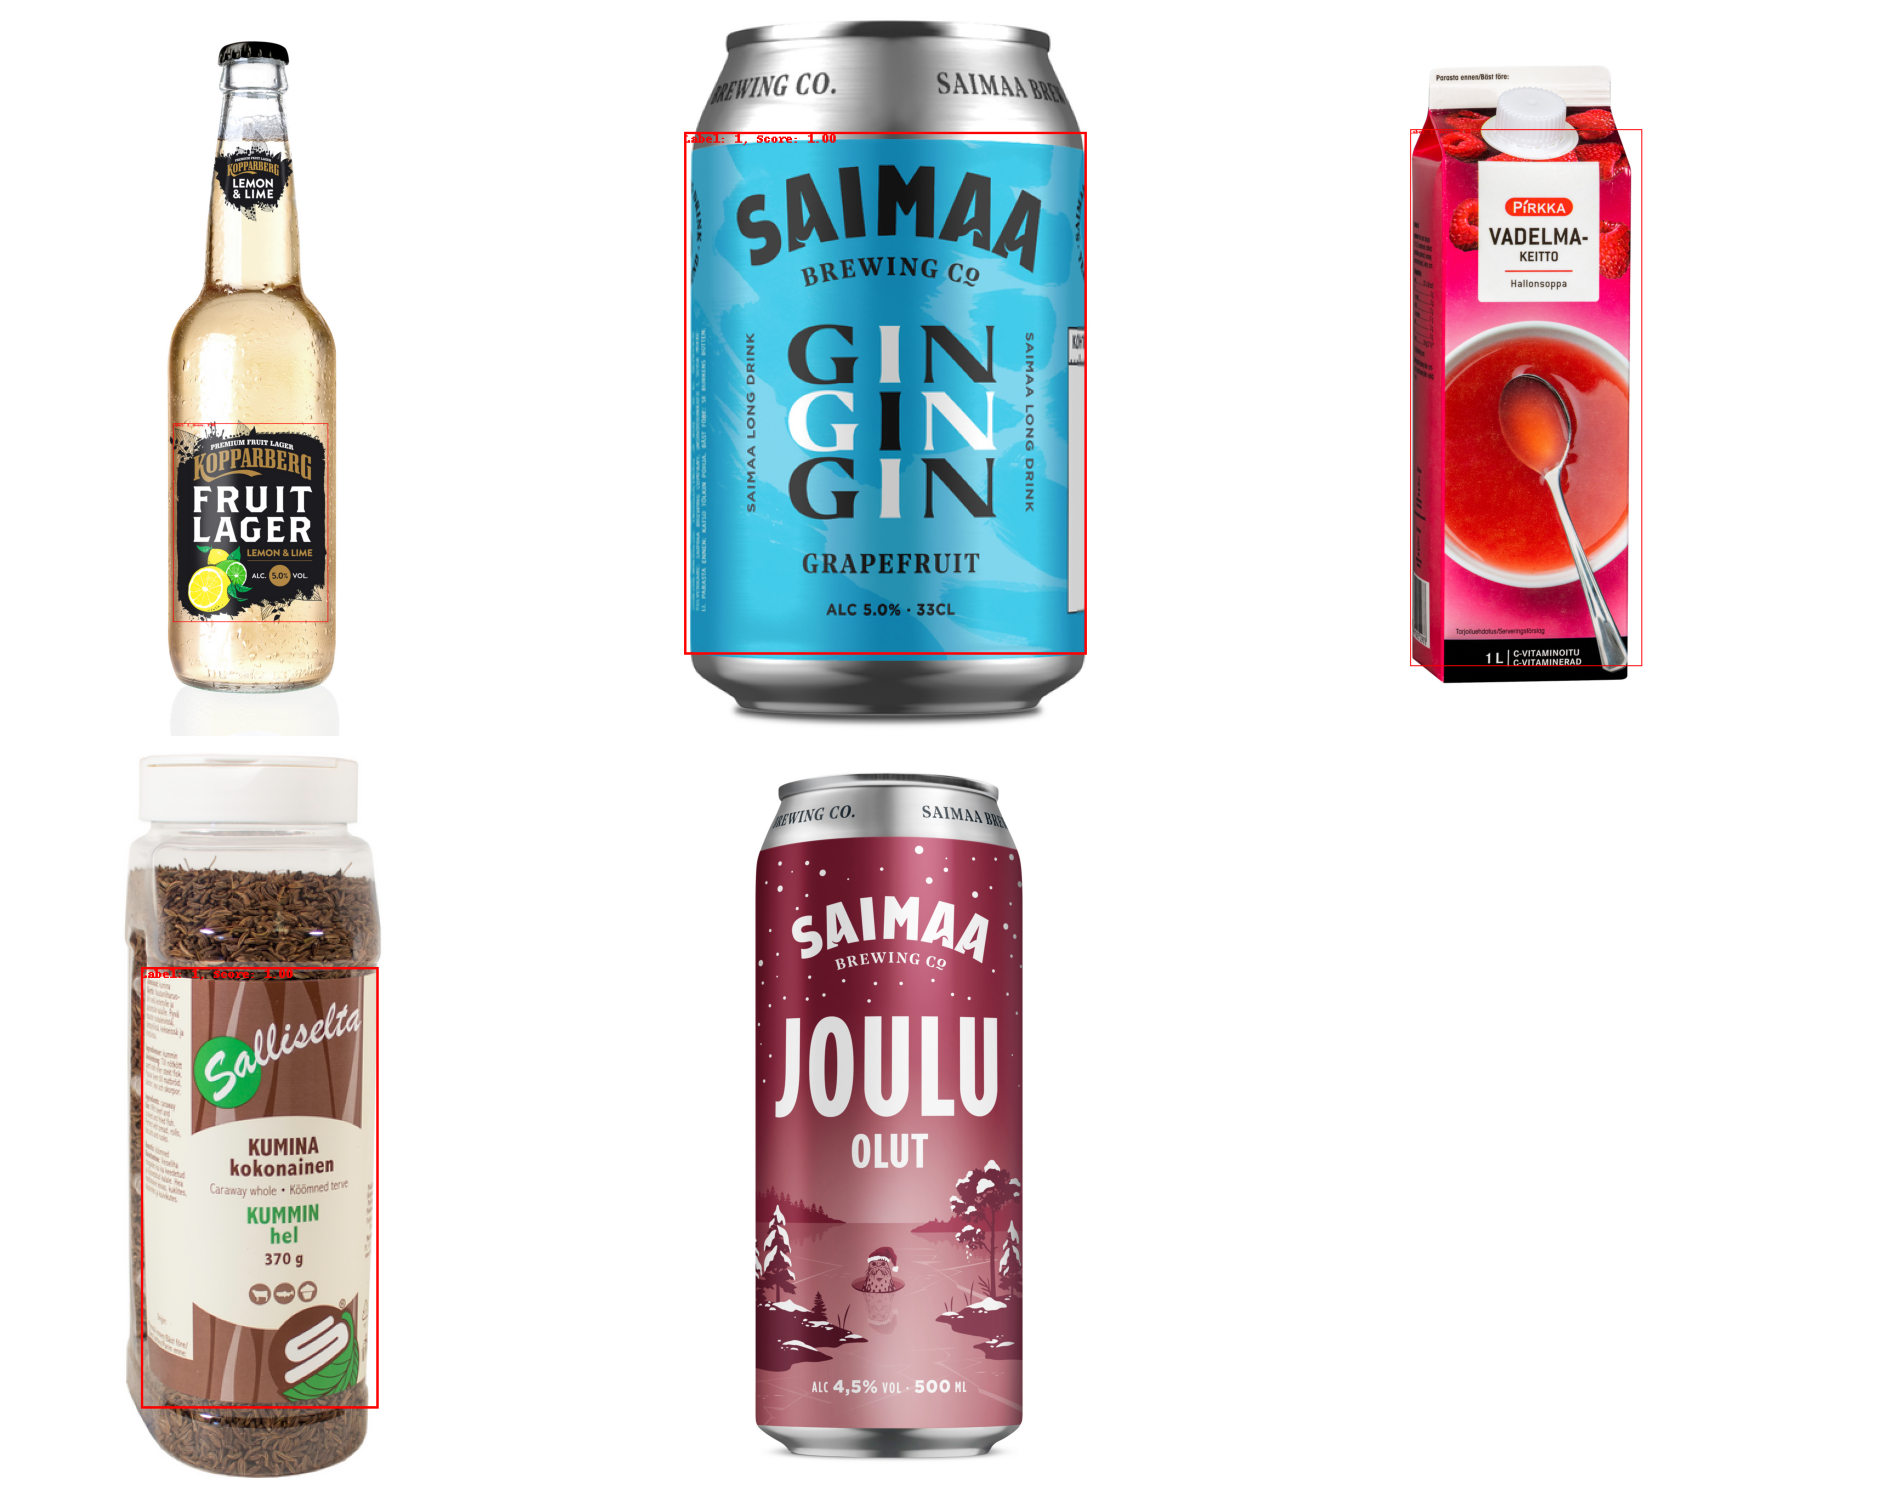

In [ ]:
# Määritellään polut
MODEL_PATH = '/content/drive/MyDrive/mansikka/datas/label_detection_model_last_epoch_12.pth'  # Muuta tämä tarvittaessa
IMAGE_DIR = '/content/drive/MyDrive/mansikka/datas/photos'  # Muuta tämä tarvittaessa

# Mallin alustaminen
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Lataa malli
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# Funktio satunnaisten kuvien valitsemiseen
def select_random_images(num_images=5):
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(image_files, min(num_images, len(image_files)))
    images = [Image.open(os.path.join(IMAGE_DIR, file)).convert("RGB") for file in selected_files]
    return images

# Visualisointi
def visualize_prediction(image, prediction):
    draw = ImageDraw.Draw(image)

    for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
        if score > 0.1:  # Näytä ennustukset, joiden todennäköisyys on yli 10%
            box = box.cpu().numpy()
            draw.rectangle(box, outline="red", width=2)
            draw.text((box[0], box[1]), f"Label: {label.item()}, Score: {score:.2f}", fill="red")

    return image

# Valitse ja käsittele kuvat
images = select_random_images(num_images=5)

# Tee ennustus ja visualisoi jokainen kuva
plt.figure(figsize=(20, 15))
for idx, img in enumerate(images):
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)
    img_with_predictions = visualize_prediction(img, prediction)

    plt.subplot(2, 3, idx + 1)
    plt.imshow(img_with_predictions)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Testataan mallia manuaalisesti URL kuvilla

In [1]:
image_urls = [
    "https://images.alko.fi/images/cs_srgb,f_auto,t_medium/cdn/906671/newton-skyside-chardonnay-2016.jpg"
    # Lisää tähän haluamasi kuva-URL:t
]

MODEL_PATH = '/content/drive/MyDrive/mansikka/datas/label_detection_model_last_epoch_12.pth'

In [2]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import random
import requests
import io
import numpy as np
import matplotlib.patches as patches


Ennustuksen tiedot kuvalle 1:
[{'boxes': tensor([[  16.5614, 1284.4984,  571.1149, 1825.4609]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}]


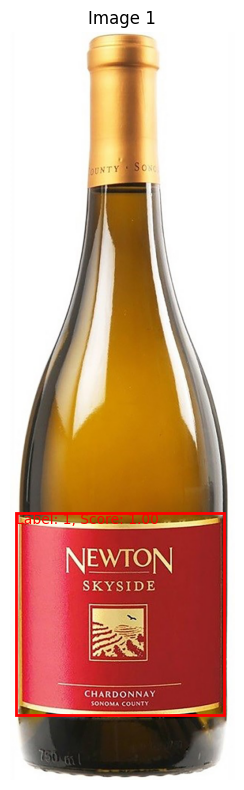

In [5]:
# Mallin alustaminen
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Lataa malli
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# Lataa kuva URL:sta
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content)).convert("RGB")
    return img

# Visualisoi ennuste
def visualize_prediction(image, prediction, ax):
    img = np.array(image)
    ax.imshow(img)

    for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
        if score > 0.5:  # Näytä ennustukset, joiden todennäköisyys on yli 10%
            box = box.cpu().numpy()
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(box[0], box[1], f"Label: {label.item()}, Score: {score:.2f}",
                    color='red', fontsize=10, verticalalignment='top')

    ax.axis('off')

# Testaa mallia useilla kuvilla
def test_images(image_urls):
    num_images = len(image_urls)
    fig, axs = plt.subplots(num_images, 1, figsize=(12, 8*num_images))
    if num_images == 1:
        axs = [axs]

    for i, url in enumerate(image_urls):
        img = load_image_from_url(url)
        img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(img_tensor)

        visualize_prediction(img, prediction, axs[i])
        axs[i].set_title(f"Image {i+1}")

        print(f"\nEnnustuksen tiedot kuvalle {i+1}:")
        print(prediction)

    plt.tight_layout()
    plt.show()

    # Tallenna kuva
    # fig.savefig('/content/drive/MyDrive/neuroverkot/multi_image_predictions.png', bbox_inches='tight')
    # print("Ennustuksen visualisointi tallennettu: /content/drive/MyDrive/neuroverkot/multi_image_predictions.png")


test_images(image_urls)
